[View in Colaboratory](https://colab.research.google.com/github/findingfoot/ML_practice-codes/blob/master/Logistic_Regression.ipynb)

In [0]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.python.framework import ops
import os.path
import csv
import requests
from jupyterthemes import jtplot

jtplot.style(context='talk', fscale=1.4, spines=False, gridlines='--')


In [0]:
ops.reset_default_graph()

In [0]:
sess = tf.Session()

In [0]:

# name of data file
birth_weight_file = 'birth_weight.csv'

# download data and create data file if file does not exist in current directory
if not os.path.exists(birth_weight_file):
    
    birthdata_url = 'https://github.com/nfmcclure/tensorflow_cookbook/' + \
    'raw/master/01_Introduction/07_Working_with_Data_Sources/birthweight_data/birthweight.dat'
    birth_file = requests.get(birthdata_url)
    birth_data = birth_file.text.split('\r\n')
    birth_header = birth_data[0].split('\t')
    birth_data = [[float(x) for x in y.split('\t') if len(x)>=1] for y in birth_data[1:] if len(y)>=1]
    with open(birth_weight_file, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(birth_header)
        writer.writerows(birth_data)
        f.close()

In [0]:
birth_data = []
with open(birth_weight_file, newline='') as csvfile:
    csv_reader = csv.reader(csvfile)
    birth_header = next(csv_reader)
    for x in csv_reader:
        birth_data.append(x)

In [0]:
birth_data = [[float(x) for x in row] for row in birth_data]
print(type(birth_data))


<class 'list'>


In [0]:
y_vals = np.array([x[0] for x in birth_data]) #target
x_vals = np.array([x[1:8]for x in birth_data]) #predictors


In [0]:
#reproducible experiment

seed = 23
np.random.seed(seed)
tf.set_random_seed(seed)

In [0]:
#train and test split

train_indices = np.random.choice(len(x_vals), round(len(x_vals)*0.8), replace = False)
test_indices = np.array(list(set(range(len(x_vals))) - set(train_indices)))

x_vals_train = x_vals[train_indices]
x_vals_test = x_vals[test_indices]

y_vals_train = y_vals[train_indices]
y_vals_test = y_vals[test_indices]


In [0]:
z =y_vals_train
z

array([1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1.])

In [0]:
# need to normalize the data column wise

def normalize_col(m, col_min = np.array([None]), col_max = np.array([None])):
    if not col_min[0]:
        col_min = m.min(axis=0)
    if not col_max[0]:
        col_max = m.max(axis=0)
    return (m-col_min) / (col_max - col_min), col_min, col_max
    

In [0]:
x_vals_train, train_min, train_max = np.nan_to_num(normalize_col(x_vals_train))

In [0]:
train_min

array([14., 80.,  0.,  0.,  0.,  0.,  0.])

In [0]:
train_max

array([ 45., 250.,   1.,   1.,   1.,   1.,   1.])

In [0]:
x_vals_test, _, _ = np.nan_to_num(normalize_col(x_vals_test, train_min, train_max))

In [0]:
batch_size = 25

x_data = tf.placeholder(shape=[None,7], dtype=tf.float32)
y_target = tf.placeholder(shape = [None,1], dtype=tf.float32)


A = tf.Variable(tf.random_normal(shape = [7,1]))
b = tf.Variable(tf.random_normal(shape = [1,1]))

model_output = tf.add(tf.matmul(x_data, A), b)

loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits
                      (logits = model_output, labels= y_target))

my_opt = tf.train.GradientDescentOptimizer(0.02)
train_step = my_opt.minimize(loss)

In [0]:
init = tf.global_variables_initializer()
sess.run(init)

In [0]:
#actual predictions

prediction = tf.round(tf.sigmoid(model_output))
correct_prediction = tf.cast(tf.equal(prediction, y_target), dtype=tf.float32)
accuracy = tf.reduce_mean(correct_prediction)

In [0]:
#training 

loss_vec = []
train_acc = []
test_acc = []

for i in range(1500):
    rand_index = np.random.choice(len(x_vals_train), size = batch_size )
    rand_x = x_vals_train[rand_index]
    rand_y = np.transpose([y_vals_train[rand_index]])
    sess.run(train_step, feed_dict={x_data: rand_x, y_target:rand_y})
    
    temp_loss = sess.run(loss, feed_dict={x_data: rand_x, y_target: rand_y})
    loss_vec.append(temp_loss)
    
    #accuracy
    
    temp_acc_train = sess.run(accuracy, feed_dict={x_data: x_vals_train, 
                                                   y_target: np.transpose([y_vals_train])})
    
    train_acc.append(temp_acc_train)
    
    #test accuracy
    
    temp_acc_test = sess.run(accuracy, feed_dict={x_data: x_vals_test, 
                                                  y_target: np.transpose([y_vals_test])})
    
    test_acc.append(temp_acc_test)
    
    if(i+1)%500 ==0:
        print('Loss = ' + str(temp_loss))
        #print('Train accuracy =' + str(temp_acc_train))
        #print('Test accuracy = '+ str(temp_acc_test))

Loss = 0.6814911
Loss = 0.55801725
Loss = 0.47210395


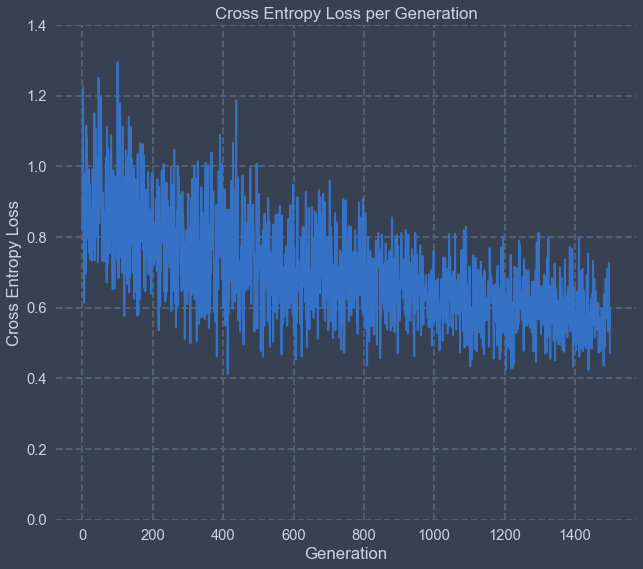

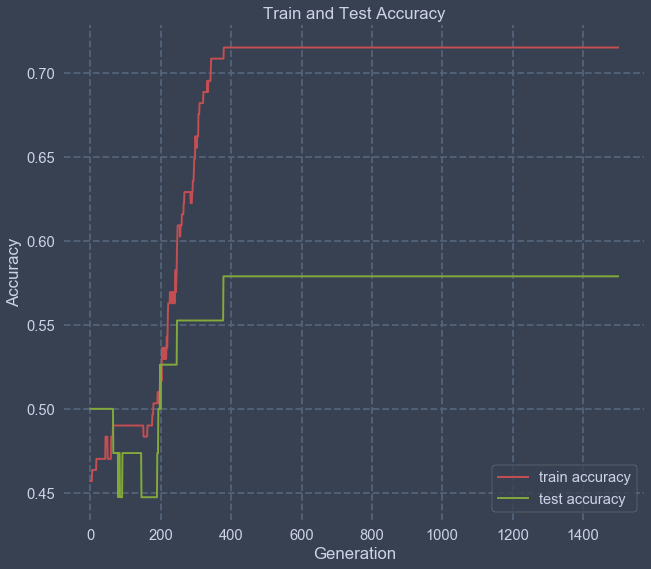

In [0]:
plt.plot(loss_vec, 'b-')
plt.title('Cross Entropy Loss per Generation')
plt.ylim(0,1.4)
plt.xlabel('Generation')
plt.ylabel('Cross Entropy Loss')
plt.show()



#plot train Vs test accuracy

plt.plot(train_acc, 'r-', label = 'train accuracy')
plt.plot(test_acc, 'g-', label = 'test accuracy')
plt.title('Train and Test Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()